# DMML WS24:  Gruppenarbeit

## 1. Wiedergabe der Angabe 

### 1.1 Allgemeine Aufgabenstellung 

Bewertungsgrundlagen: 
- Zum Code: 
    - Lauffähigkeit des gesamten Codes (Daten liegen im selben Ordner wie das Notebook). 
    - Vermeidung von Warnmeldungen (soweit möglich). 
    - Kein unnötiger Code, keine Auswertungen/Plots ohne Aussagekraft 
    - Kommentierungen, was der Code macht, sind sinnvoll, werden nicht bewertet. 
    - Verweise bei verwendeten Codeschnipsel aus einer externen Quelle (bspw. Stack Overflow, ChatGPT, Notebooknamen aus Vorlesung/Übung, etc.). 
- Zum Inhalt: 
    - Jeder Plot und jede Auswertung sind zu kommentieren! (was kann man daraus ablesen, warum macht dieser Plot/Auswertung einen Sinn?) 
    - Datenanalyse vor der Modellierung (Data Understanding). 
    - Jede Datenmanipulation muss erklärt und begründet werden (Data Preparation). 
    - Es sind verschiedene Vorgangsweisen/Modelle miteinander zu vergleichen. 
    - Die Anzahl der Datensätze, die Anzahl der Spalten sowie die Ausgewogenheit (unbalanced?) ist bei der Datenvorbereitung und der Modellbildung zu berücksichtigen. 
- Methoden, Modelle, Modellbewertung: 
    - VIFs sind zu berechnen – sofern sinnvoll. 
    - Die Metrik(en) zur Bewertung der Ergebnisse sind selbst festzulegen und zu begründen. 
    - Einsatz einer Dimensionsreduktion ist zu prüfen, oder Nichteinsatz ist zu begründen. 
    - Erklärung, warum (und wie) oder warum nicht eine Featureauswahl vorgenommen wurde. 
    - Erklärung, warum (und wie) oder warum nicht Feature Engineering vorgenommen wurde. 
    - Hyperparameter sind zu optimieren. 
    - Beim Modellvergleich soll gezeigt werden, dass ein Modell nicht nur zufällig besser ist. 
    - Ergebnisse sind (verfahrensabhängig) graphisch oder tabellarisch darzustellen- dazu gehören bspw. (Konfusionsmatrix, ROC-Kurve, Auswertungen „Feature-Importance“), Tree plot …). 
    - Darstellung, ob es Indizien für Over- oder Underfitting gibt. 
    - Am Ende soll ein Vorschlag für eine Klassifikation (Darstellung der Schritte in der Datenvorbereitung und verwendets Modell inkl. Parameter) gemacht werden.

### 1.2 Gruppenspezifsche Aufgabenstellung - A5 DDoS 

DDoS, or Distributed Denial of Service, is an attack in which traffic from different sources floods a victim, 
resulting in service interruption. There are many types of DDoS attacks, falling under three general categories: 
application-level, protocol, and volumetric attacks. 

Much of the DDoS defense today is manual. Certain IP addresses or domains are identified and then blocked. 
As DDoS bots become more sophisticated, such approaches are becoming outdated. Machine learning offers 
a promising automated solution. 

The dataset we will be working with is a subsampling of the CSE-CIC-IDS2018, CICIDS2017, and CIC DoS 
datasets (2017). It consists of 80% benign and 20% DDoS traffic, in order to represent a more realistic ratio 
of normal-to-DDoS traffic.*

Die Daten liegen in der Datei: ddos_dataset.csv.

Aufgrund der vielen Datensätze sollen die 100.000 aktuellsten Datensätze gleich zu Beginn als Testdatensätze entfernt werden. 

Nach der erfolgten Modellauswahl soll das Modell diese 100.000 Datensätze klassifizieren. Vergleicht die 
damit erreichte Güte mit den Modellgüte bei der Modellauswahl. Könnt ihr eine Erklärung dafür geben? 

*Anmerkung: "80 % normaler Datenverkehr, 20 % DDoS-Angriffe"

## 2. Verwendete Bibilotheken 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.utils import shuffle


# Import dstools (absolute path required, please change to your systems settings)
import importlib
import sys

path = '/dstools-master/dstools/__init__.py'
name = 'dstools'

spec = importlib.util.spec_from_file_location(name, path)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

from dstools.tools import quality


## 3. Datenanlyse 

### 3.1 Importieren der Daten

In [22]:
df = pd.read_csv("ddos_dataset.csv")
df.head(5)  

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,22/02/2018 12:27:57 AM,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,16/02/2018 11:18:14 PM,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,16/02/2018 11:23:20 PM,114.333333,114.333333,-1,219,0,ddos
3,172.31.69.25-18.219.193.20-80-53346-6,16/02/2018 11:22:41 PM,233.750000,233.750000,-1,211,0,ddos
4,172.31.69.28-18.218.55.126-80-57856-6,21/02/2018 11:49:25 PM,233.750000,233.750000,-1,32768,0,ddos


### 3.2 Anpassung des Datensatzes zur erleichterten Interpretation

Bevor das Datenset analysiert wird, werden die Leerzeichen in den Feature-Bezeichnern durch Unterstriche (_) ersetzt. Anschließend wird der Timestamp in das datetime-Format umgewandelt und die Flow_ID in ihre Bestandteile getrennt.

Zuletzt werden die Einträge nach ihrem zeitlichen Eintreten (Timestamp) sortiert und auf das Vorhandensein von Duplikaten kontrolliert.

In [23]:
df.rename(columns={"Flow ID": "Flow_ID", "Fwd Pkt Len Mean": "Fwd_Pkt_Len_Mean", "Fwd Seg Size Avg": "Fwd_Seg_Size_Avg", "Init Fwd Win Byts": "Init_Fwd_Win_Byts", "Init Bwd Win Byts": "Init_Bwd_Win_Byts", "Fwd Seg Size Min": "Fwd_Seg_Size_Min"}, inplace=True)

In [24]:
def parse_mixed_timestamps(timestamp):
    if "AM" in timestamp or "PM" in timestamp: 
        return pd.to_datetime(timestamp, format="%d/%m/%Y %I:%M:%S %p") # %I, %p: 12h-format if AM/PM is used
    else:  # 24h-format 
        return pd.to_datetime(timestamp, format="%d/%m/%Y %H:%M:%S")

df["Timestamp"] = df["Timestamp"].apply(parse_mixed_timestamps)

In [25]:
df[["Source_IP", "Destination_IP", "Source_Port", "Destination_Port", "Protocol"]] = df["Flow_ID"].str.split("-", expand=True)

In [26]:
df = df.sort_values(by='Timestamp') # Timestamps are mixed up 

In [27]:
# Count duplicates
duplicate_count = df.duplicated().sum()
print(f"Anzahl der Duplikate: {duplicate_count}")

Anzahl der Duplikate: 437


Von insgesamt 500.000 Einträgen erweisen sich 437 als Duplikate. Aufgrund des Wirkprinzips von DDoS-Angriffen, bei denen wiederholte Anfragen von denselben oder ähnlichen Quellen zu einem Anstieg von identischen Einträgen führen können, und der Möglichkeit, dass der Unterschied möglicherweise in nicht erfassten Hundertstelsekunden liegt, werden die Duplikate nicht entfernt.

In [28]:
df.head(5)

,Flow_ID,Timestamp,Fwd_Pkt_Len_Mean,Fwd_Seg_Size_Avg,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Seg_Size_Min,Label,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol
34877,192.168.4.118-203.73.24.75-4559-80-6,2010-06-12 08:37:25,46.000000,46.000000,-1,5840,0,ddos,192.168.4.118,203.73.24.75,4559,80,6
42371,192.168.4.118-203.73.24.75-4567-80-6,2010-06-12 08:37:44,0.000000,0.000000,-1,17520,0,ddos,192.168.4.118,203.73.24.75,4567,80,6
14239,192.168.2.110-69.84.133.138-3955-80-6,2010-06-12 08:43:50,7.777778,7.777778,-1,65465,0,ddos,192.168.2.110,69.84.133.138,3955,80,6
28665,192.168.2.110-67.220.214.50-4161-80-6,2010-06-12 09:12:34,30.000000,30.000000,-1,5840,0,ddos,192.168.2.110,67.220.214.50,4161,80,6
79376,192.168.2.110-67.220.214.50-4269-80-6,2010-06-12 09:13:08,31.500000,31.500000,-1,5840,0,ddos,192.168.2.110,67.220.214.50,4269,80,6


Bereits bei der Ausgabe von den ersten fünf Einträgen fällt auf, dass ein DDoS-Angriff mehrere Einträge des Datensatzes umfassen kann, jedoch nicht jeder Eintrag mit einem anderen Eintrag in Verbindung stehen muss. Beispielsweise dürfte Eintrag 34877 mit Eintrag 42371 in einer Beziehung stehen (gleiche Source_IP und Destination_IP), aber zu Eintrag 14239 keine Verbindung bestehen.

Aus dem obigen Absatz muss daher der Schluss gezogen werden, das dieser Datensatz zwar einen zeitlichen Verlauf darstellen, man aber nicht aus vorgehenden Datensätzen auf den nächsten Datensatz schließen darf, auch wenn man von vermehrten Anfragen in bestimmten Zeitfenstern vielleicht auf DDoS-Angriffen schließen kann.

### 3.3 Explorative Datenanalyse

Der Datensatz umfasst 500.000 Einträge und besteht nach der ersten Vorverarbeitung aus 13 Variablen. 

Die Daten wurden im Zeitraum von 2010-06-12 bis 2018-02-22 erfasst und geben die Parameter an, welche im Zusammenhang mit einem normalen Datenverekehr oder einem DDoS-Angriff aufgetreten sind. Die Abstände zwischen den Zeitstempeln variieren.

In [29]:
df.describe()

,Timestamp,Fwd_Pkt_Len_Mean,Fwd_Seg_Size_Avg,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Seg_Size_Min
count,500000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,2018-02-03 00:00:13.072000,59.599088,59.599088,3896.730814,10062.633854,12.050744
min,2010-06-12 08:37:25,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,2018-02-20 01:58:40,0.000000,0.000000,-1.000000,-1.000000,0.000000
50%,2018-02-20 04:59:02,38.000000,38.000000,-1.000000,110.000000,8.000000
75%,2018-02-20 10:48:38,74.600000,74.600000,8192.000000,358.000000,20.000000
max,2018-02-22 00:35:54,4262.882353,4262.882353,65535.000000,65535.000000,44.000000
std,NaN,74.798045,74.798045,9478.710467,20979.138503,8.654627


In [30]:
quality(df)

Dataframe has 500,000 rows and 13 columns.

0 column(s) with missing values.

4 column(s) with outliers.



,type,unique,missing_abs,missing_rel,outliers_abs,outliers_rel
Flow_ID,object,438039,0,0.0,0,0.00
Timestamp,datetime64[ns],51423,0,0.0,0,0.00
Fwd_Pkt_Len_Mean,float64,15620,0,0.0,46202,9.24
Fwd_Seg_Size_Avg,float64,15388,0,0.0,46202,9.24
Init_Fwd_Win_Byts,int64,2442,0,0.0,12118,2.42
Init_Bwd_Win_Byts,int64,4033,0,0.0,122773,24.55
Fwd_Seg_Size_Min,int64,9,0,0.0,0,0.00
Label,object,2,0,0.0,0,0.00
Source_IP,object,2199,0,0.0,0,0.00
Destination_IP,object,18626,0,0.0,0,0.00


Die Auswertung zeigt, dass die Features Fwd_Pkt_Len_Mean, Fwd_Seg_Size_Avg, Init_Fwd_Win_Byts, und Init_Bwd_Win_Byts von starken Ausreißern beeinflusst werden. Dies lässt sich an den erheblichen Unterschieden zwischen dem Median ("50%") und den Maximalwerten ("max") erkennen, wie sie in der Übersicht von df.describe() hervorgehoben wurden.
Darüber hinaus weisen viele dieser Features 0 oder -1 als Minimum auf. Nach einer Recherche wurde festgestellt, dass diese Werte tatsächlich möglich sind.

Des weiteren ist erkennbar, dass keines der unrsprünglichen und aus Flow-ID generierten Features von fehlenden Einträgen betroffen ist. 

### 3.3.1 Variablen

In der folgenden Auflistung werden die Variablen des Datensatzes näher beschrieben. 

- Flow_ID (auch aufgeteilt in: "Source_IP", "Destination_IP", "Source_Port", "Destination_Port" und "Protocol")
    - Beispiel: 172.31.69.28-18.216.200.189-80-52169-6 
    - 172.31.69.28: Dies ist die Quell-IP-Adresse (Source IP), die die IP-Adresse des Computers oder Geräts angibt, das die Kommunikation initiiert.
    - 18.216.200.189: Dies ist die Ziel-IP-Adresse (Destination IP), die die IP-Adresse des Computers oder Geräts angibt, mit dem die Quelle kommuniziert.
    - 80: Dies ist der Quellport (Source Port), der angibt, welcher Port auf der Quell-IP-Adresse für die Kommunikation verwendet wird. 
    - 52169: Dies ist der Zielport (Destination Port), der den Port auf der Ziel-IP-Adresse darstellt, über den die Kommunikation erfolgt.
    - 6: Dies stellt das verwendete Protokoll dar, das in diesem Fall den Wert 6 hat, was für TCP (Transmission Control Protocol) steht. 
- Timestamp
    - Beispiel: 2018-02-22 00:27:57
    - Ausprägungen: 2010-06-12 08:37:25 bis 2018-02-22 00:35:54 
    - Datumsformat (JJJJ-MM-TT hh:mm:ss)
- Fwd_Pkt_Len_Mean (Durchschnittliche Länge der Forward-Pakete)
    - Beispiel: 38 (Median)
    - Ausprägungen: 0 bis 4262.882353	
    - Diese Metrik gibt die durchschnittliche Größe der Pakete im Forward-Verkehr (also vom Client zum Server) an. Ein plötzlicher Anstieg der durchschnittlichen Paketgröße könnte darauf hinweisen, dass mehr Daten in kürzerer Zeit übertragen werden, was bei einem DDoS-Angriff oder ungewöhnlichem Traffic häufig vorkommen kann.
- Fwd_Seg_Size_Avg (Durchschnittliche Segmentgröße der Forward-Daten)
    - Beispiel: 38 (Median)
    - Ausprägungen: 0 bis 4262.882353
    - Dies gibt die durchschnittliche Größe eines Segments im Forward-Verkehr an. Eine größere Segmentgröße könnte darauf hinweisen, dass der Verkehr anders strukturiert ist (z. B. durch Angriffe oder spezielle Netzwerkaktivitäten).
- Init_Fwd_Win_Byts (Initiale Größe des Forward-Fensters)
    - Beispiel: -1.0 (Median)
    - Ausprägungen: -1 bis 65535
    - Diese Metrik gibt die initiale Fenstergröße in Bytes für den Forward-Verkehr an. Ein kleines Fenster könnte auf eine limitierte Bandbreite hinweisen, ein großes Fenster auf eine hohe Datenübertragungsrate. Plötzliche Änderungen der Fenstergröße können mit DDoS-Angriffen oder Netzwerküberlastung in Verbindung stehen.
- Init_Bwd_Win_Byts (Initiale Größe des Backward-Fensters)
    - Beispiel: 110 (Median)
    - Ausprägungen: -1 bis 65535
    - Ähnlich wie die vorherige Metrik, aber für den Backward-Verkehr (vom Server zurück zum Client). Auch hier können plötzliche Änderungen auf Netzwerkprobleme oder Angriffe hinweisen.
- Fwd_Seg_Size_Min (Minimale Segmentgröße im Forward-Verkehr)
    - Beispiel: 8 (Median)
    - Ausprägungen: 0 bis 44
    - Diese Metrik gibt die kleinste Segmentgröße im Forward-Verkehr an. Kleinere Segmentgrößen könnten bei bestimmten Angriffen wie SYN Flood oder Ping of Death auftreten, da kleine Pakete in schnellen, wiederholten Anfragen gesendet werden.
- Label
    - Ausprägungen: Benign/ddos
    - Diese Metrik gibt an, ab es sich bei dem entsprechenden Verkehr um einen DDoS-Angriff handelt oder normalen Verkehr handelt

### 3.3.2 DDoS Angriff

Die drei Hauptarten von DDoS-Angriffen (Application-Level Attacks, Protocol Attacks, und Volumetric Attacks) unterscheiden sich in ihren Zielen und Techniken.

- Application-Level Attacks (Applikationsbasierte Angriffe)
    - Diese Angriffe konzentrieren sich darauf, die Anwendungsressourcen zu erschöpfen, z. B. Rechenleistung oder Speicherplatz.
    - Sie sind oft schwer zu erkennen, da sie echten Datenverkehr imitieren.
    - Beispiel: HTTP Floods: Eine Flut von scheinbar normalen HTTP-Anfragen wird gesendet, um die Serverkapazität zu überlasten.
    - Beispiel: Slowloris: Eine Verbindung wird geöffnet, aber nie vollständig abgeschlossen, sodass der Server blockiert wird.
    - DNS Query Floods: Übermäßige DNS-Anfragen an einen DNS-Server.
- Protocol Attacks (Protokollbasierte Angriffe)
    - Überlastet die Infrastrukturkomponenten, die den Netzwerkverkehr verarbeiten, wie etwa Firewalls und Load Balancer
    - Beispiele SYN Flood: Sendet eine große Anzahl von SYN-Anfragen ohne Abschluss der TCP-Handshake-Prozesse, wodurch der Server Ressourcen reserviert.
    - Beispiele Ping of Death: Senden von übergroßen ICMP-Paketen, die nicht verarbeitet werden können.
    - Beispiel Smurf Attack: Missbraucht ICMP-Echo-Anfragen (Ping) zur Erzeugung eines reflektierten Angriffs.
- Volumetric Attacks (Volumenbasierte Angriffe)
    - Diese Angriffe erzeugen eine massive Flut von Datenpaketen, um die Bandbreite der Zielumgebung oder der zwischengeschalteten Netzwerke (z. B. Internetprovider) zu erschöpfen.
    - UDP Flood: Eine große Anzahl von UDP-Paketen wird gesendet, um die Bandbreite zu sättigen.
    - DNS Amplification: Verstärkt den Angriff durch Nutzung offener DNS-Server, die kleine Anfragen in große Antworten umwandeln.
    - NTP Amplification: Nutzt Schwachstellen in Netzwerkzeitservern (NTP), um riesige Datenströme zu generieren.

Mischformen oder kombinierte DDoS-Angriffe sind durchaus möglich und werden oft eingesetzt, um ihre Effektivität zu maximieren und gleichzeitig die Erkennung und Abwehr zu erschweren.


### 3.3.2 Visualisierungen

Mit den folgenden Visualisierungen wird versucht, grundlegende Muster und Zusammenhänge innerhalb des Datensatzes zu identifizieren, um ein besseres Verständnis der Netzwerkaktivitäten zu gewinnen.

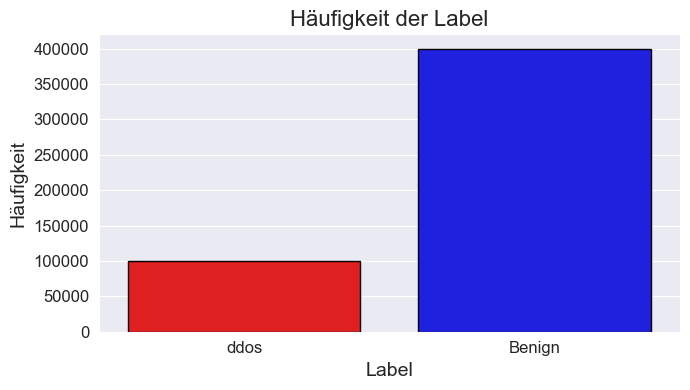

In [31]:
# Häufigkeit der Label
plt.figure(figsize=(7, 4))
sns.countplot(x='Label', hue='Label', data=df, palette={'Benign': 'blue', 'ddos': 'red'}, edgecolor='black')
plt.title('Häufigkeit der Label', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

Die obige Grafik zeigt, dass DDoS-Angriffe im Datensatz signifikant seltener auftreten als normale Netzwerkaktivitäten. Von allen Einträgen des Datensatzes stellen 100.000 DDoS-Agriffe dar, während 400.000 normalen Netzwerkaktivitäten entsprechen. 

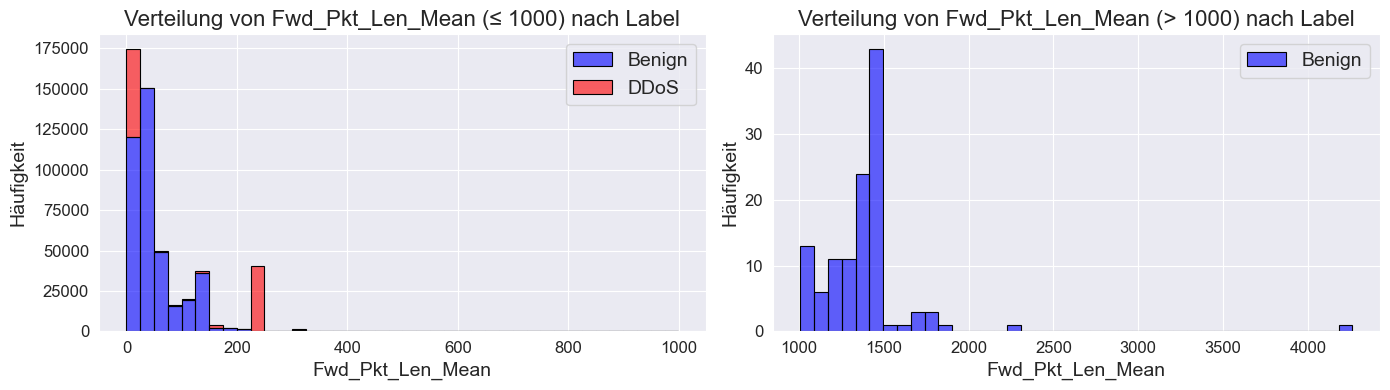

In [32]:
# Verteilung von Fwd_Pkt_Len_Mean (≤ 1000) nach Label und Verteilung von Fwd_Pkt_Len_Mean (> 1000) nach Label 

df_small = df[df['Fwd_Pkt_Len_Mean'] <= 1000]
df_large = df[df['Fwd_Pkt_Len_Mean'] > 1000]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# Plot for Fwd_Pkt_Len_Mean ≤ 1000
sns.histplot(data=df_small, x='Fwd_Pkt_Len_Mean', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[0])
axes[0].set_title('Verteilung von Fwd_Pkt_Len_Mean (≤ 1000) nach Label', fontsize=16)
axes[0].set_xlabel('Fwd_Pkt_Len_Mean', fontsize=14)
axes[0].set_ylabel('Häufigkeit', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(labels=['Benign', 'DDoS'], fontsize=14)

# Plot for Fwd_Pkt_Len_Mean > 1000
sns.histplot(data=df_large, x='Fwd_Pkt_Len_Mean', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[1])
axes[1].set_title('Verteilung von Fwd_Pkt_Len_Mean (> 1000) nach Label', fontsize=16)
axes[1].set_xlabel('Fwd_Pkt_Len_Mean', fontsize=14)
axes[1].set_ylabel('Häufigkeit', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(labels=['Benign', 'DDoS'], fontsize=14)

plt.tight_layout();


Die obige Grafik zeigt, dass DDoS-Angriffe vor allem dann auftreten, wenn Fwd_Pkt_Len_Mean (Durchschnittliche Länge der Forward-Pakete) sehr klein ist oder eine Größe zwischen 200 und 300 besitzen. Des weiteren ist festzuhalten, dass Fwd_Pkt_Len_Mean starke Ausreißer nach oben hat, welche jedoch keine DDoS-Angriffe enthalten (siehe Grafik rechts). 

Des weiteren ist erkennbar, dass DDoS-Angriffe vermehrt in bestimmten Intervallen von Fwd_Pkt_Len_Mean auftreten. 

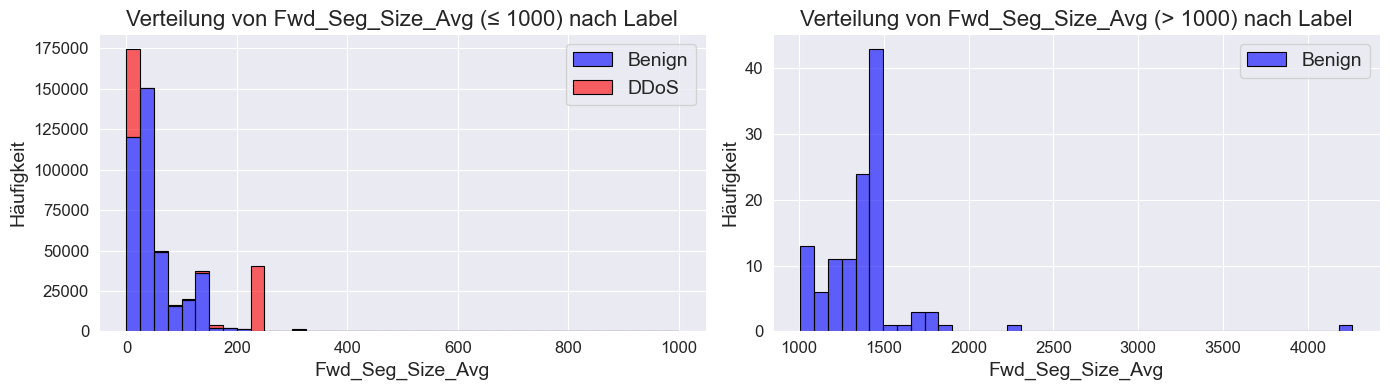

In [33]:
# Verteilung von Fwd_Seg_Size_Avg (≤ 1000) nach Label und Verteilung von Fwd_Seg_Size_Avg (> 1000) nach Label 

df_small = df[df['Fwd_Seg_Size_Avg'] <= 1000]
df_large = df[df['Fwd_Seg_Size_Avg'] > 1000]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# Plot for Fwd_Seg_Size_Avg ≤ 1000
sns.histplot(data=df_small, x='Fwd_Seg_Size_Avg', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[0])
axes[0].set_title('Verteilung von Fwd_Seg_Size_Avg (≤ 1000) nach Label', fontsize=16)
axes[0].set_xlabel('Fwd_Seg_Size_Avg', fontsize=14)
axes[0].set_ylabel('Häufigkeit', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(labels=['Benign', 'DDoS'], fontsize=14)

# Plot for Fwd_Seg_Size_Avg > 1000
sns.histplot(data=df_large, x='Fwd_Seg_Size_Avg', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[1])
axes[1].set_title('Verteilung von Fwd_Seg_Size_Avg (> 1000) nach Label', fontsize=16)
axes[1].set_xlabel('Fwd_Seg_Size_Avg', fontsize=14)
axes[1].set_ylabel('Häufigkeit', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(labels=['Benign', 'DDoS'], fontsize=14)

plt.tight_layout();


Die Verteilung von Fwd_Seg_Size_Avg (Durchschnittliche Segmentgröße der Forward-Daten) verhält sich sehr ähnlich der Verteilung von Fwd_Pkt_Len_Mean (Durchschnittliche Länge der Forward-Pakete). Auch hier bestehen starke Ausreißer nach oben. 

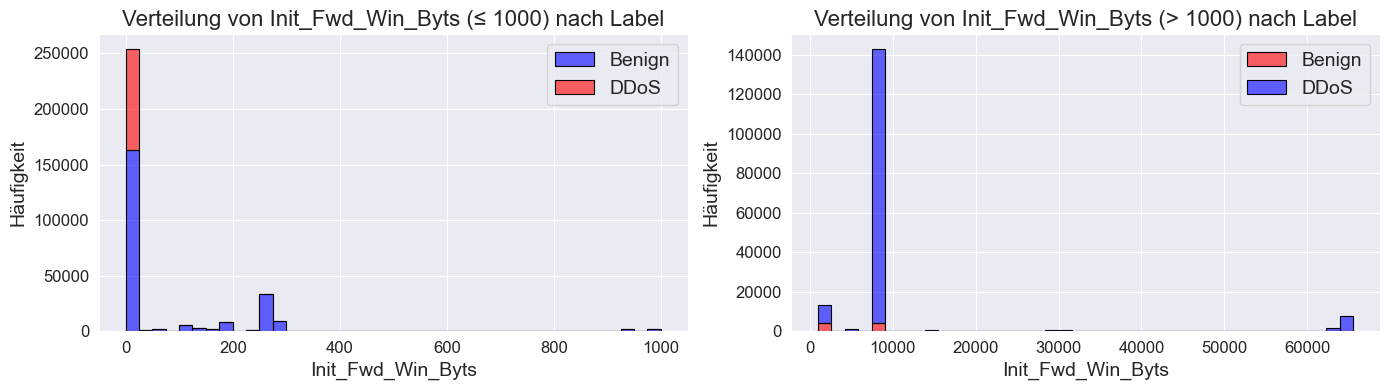

In [34]:
# Verteilung von Init_Fwd_Win_Byts (≤ 1000) nach Label und Verteilung von Init_Fwd_Win_Byts (> 1000) nach Label 

df_small = df[df['Init_Fwd_Win_Byts'] <= 1000]
df_large = df[df['Init_Fwd_Win_Byts'] > 1000]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# Plot for Init_Fwd_Win_Byts ≤ 1000
sns.histplot(data=df_small, x='Init_Fwd_Win_Byts', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[0])
axes[0].set_title('Verteilung von Init_Fwd_Win_Byts (≤ 1000) nach Label', fontsize=16)
axes[0].set_xlabel('Init_Fwd_Win_Byts', fontsize=14)
axes[0].set_ylabel('Häufigkeit', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(labels=['Benign', 'DDoS'], fontsize=14)

# Plot for Init_Fwd_Win_Byts > 1000
sns.histplot(data=df_large, x='Init_Fwd_Win_Byts', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[1])
axes[1].set_title('Verteilung von Init_Fwd_Win_Byts (> 1000) nach Label', fontsize=16)
axes[1].set_xlabel('Init_Fwd_Win_Byts', fontsize=14)
axes[1].set_ylabel('Häufigkeit', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(labels=['Benign', 'DDoS'], fontsize=14)

plt.tight_layout();


Die obige Grafik zeigt, dass DDoS-Angriffe sowohl bei einer kleinen als auch großen Größen von Init_Fwd_Win_Byts (Initiale Größe des Forward-Fensters) auftreten können. Wobei extrem große Ausreißer keine DDoS-Angriffe aufweisen.

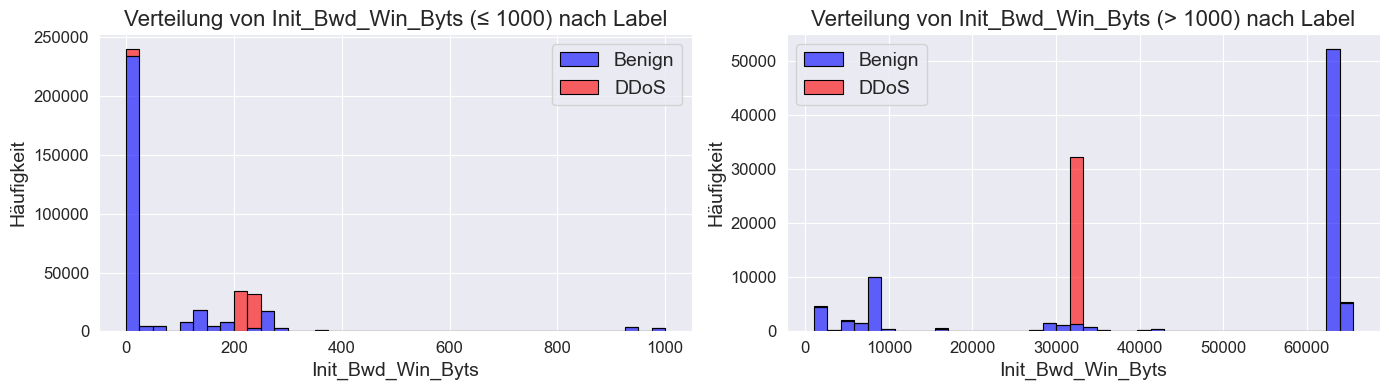

In [35]:
# Verteilung von Init_Bwd_Win_Byts (≤ 1000) nach Label und Verteilung von Init_Bwd_Win_Byts (> 1000) nach Label 

df_small = df[df['Init_Bwd_Win_Byts'] <= 1000]
df_large = df[df['Init_Bwd_Win_Byts'] > 1000]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# Plot for Init_Bwd_Win_Byts ≤ 1000
sns.histplot(data=df_small, x='Init_Bwd_Win_Byts', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[0])
axes[0].set_title('Verteilung von Init_Bwd_Win_Byts (≤ 1000) nach Label', fontsize=16)
axes[0].set_xlabel('Init_Bwd_Win_Byts', fontsize=14)
axes[0].set_ylabel('Häufigkeit', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(labels=['Benign', 'DDoS'], fontsize=14)

# Plot for Init_Bwd_Win_Byts > 1000
sns.histplot(data=df_large, x='Init_Bwd_Win_Byts', hue='Label', bins=40, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black', ax=axes[1])
axes[1].set_title('Verteilung von Init_Bwd_Win_Byts (> 1000) nach Label', fontsize=16)
axes[1].set_xlabel('Init_Bwd_Win_Byts', fontsize=14)
axes[1].set_ylabel('Häufigkeit', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(labels=['Benign', 'DDoS'], fontsize=14)

plt.tight_layout();

Die obige Grafik zeigt, dass DDoS-Angriffe sowohl bei einer kleinen als auch großen Größen von Init_Bwd_Win_Byts (Initiale Größe des Backward-Fensters) auftreten können. Wobei extrem große Ausreißer (größer 60.000) keine DDoS-Angriffe aufweisen. Es ist erkennbar, dass DDoS-Angriffe vermehrt in bestimmten Intervallen von Init_Bwd_Win_Byts auftreten. 

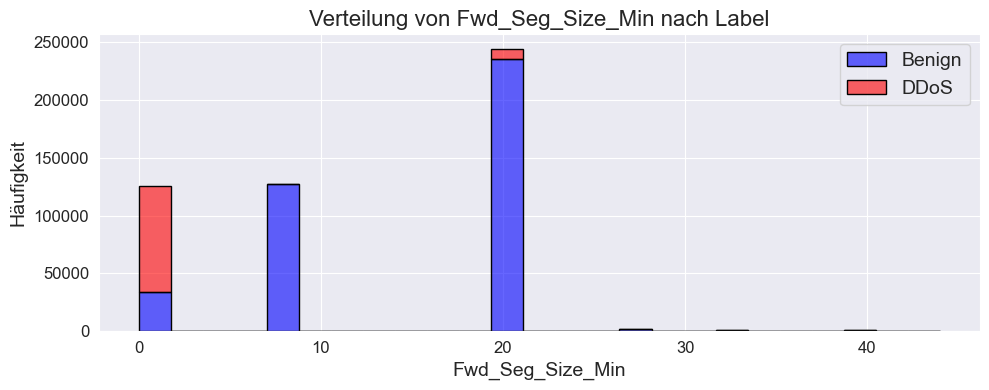

In [36]:
# Verteilung von Fwd_Seg_Size_Min nach Label und Verteilung von Init_Bwd_Win_Byts (> 1000) nach Label 
plt.figure(figsize=(10, 4))

sns.histplot(data=df, x='Fwd_Seg_Size_Min', hue='Label', bins=25, multiple='stack', palette={'Benign': 'blue', 'ddos': 'red'}, kde=False, alpha=0.6, edgecolor='black')
plt.title('Verteilung von Fwd_Seg_Size_Min nach Label', fontsize=16)
plt.xlabel('Fwd_Seg_Size_Min', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(labels=['Benign', 'DDoS'], fontsize=14)

plt.tight_layout();

Die Verteilung von Fwd_Seg_Size_Min (Minimale Segmentgröße im Forward-Verkehr) zeigt, dass sich das Aufeten der Werte auf bestimmmte Intervalle beschränkt. DDoS-Angriffen treten insbesondere bei geringen Ausprägungen von Fwd_Seg_Size_Min auf.

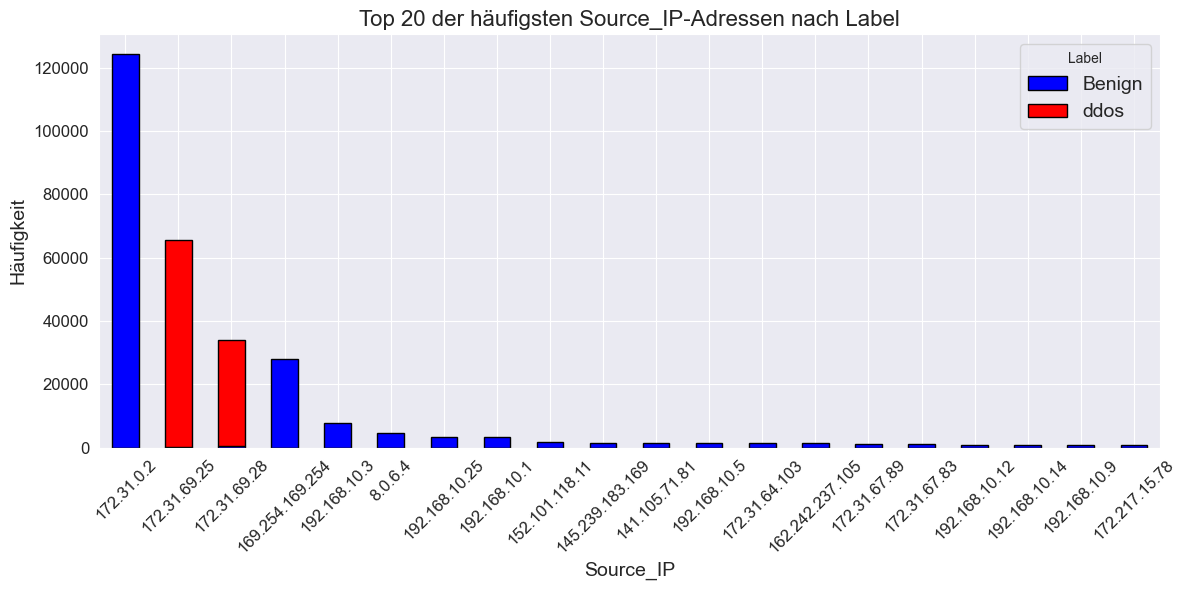

In [37]:
# Top 20 der häufigsten Source_IP-Adressen nach Label
source_ip_counts = df.groupby(['Source_IP', 'Label']).size().unstack().fillna(0)
top_20_source_ips = source_ip_counts.sum(axis=1).nlargest(20)
top_20_source_ips_df = source_ip_counts.loc[top_20_source_ips.index]

top_20_source_ips_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue', 'red'], edgecolor='black')
plt.title('Top 20 der häufigsten Source_IP-Adressen nach Label', fontsize=16)
plt.xlabel('Source_IP', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Label', fontsize=14)

plt.tight_layout();

Die obige Grafik zeigt, dass in diesem Datensatz die DDoS-Angriffe vor allem von zwei IP-Adressen (Source IP) ausgehen. Des weiteren ist erkennbar, dass rund die Hälfte aller 500.000 Einträge von den Top 5 der Source-IP-Adressen ausgehen.

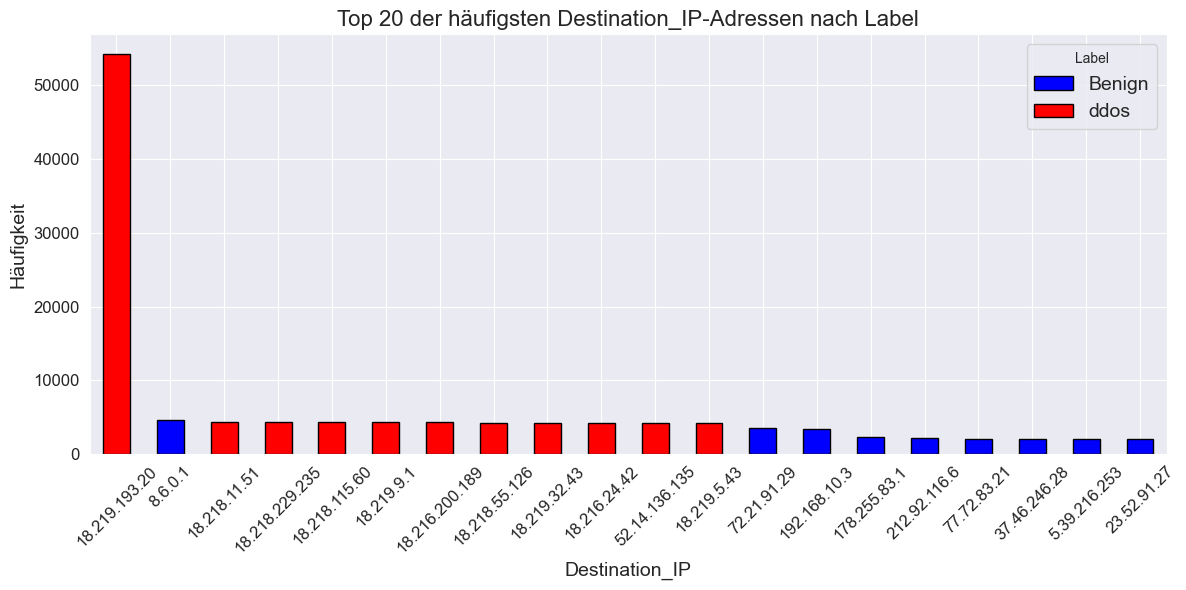

In [38]:
# Top 20 der häufigsten Destination_IP-Adressen nach Label
source_ip_counts = df.groupby(['Destination_IP', 'Label']).size().unstack().fillna(0)
top_20_source_ips = source_ip_counts.sum(axis=1).nlargest(20)
top_20_source_ips_df = source_ip_counts.loc[top_20_source_ips.index]

top_20_source_ips_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue', 'red'], edgecolor='black')
plt.title('Top 20 der häufigsten Destination_IP-Adressen nach Label', fontsize=16)
plt.xlabel('Destination_IP', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Label', fontsize=14)

plt.tight_layout();

Die Grafik zeigt, dass sich mehr als 50.000 der 500.000 Einträge des Datensatzes als DDoS-Angriffe auf die IP-Adresse 18.219.193.20 herausstellen. Sieht man von IP-Adresse 8.6.0.1 ab, fällt auf, dass wenn es zu sehr vielen Anfragen kommt, die Wahrscheinlichkeit für einen Angriff hoch sein muss. 

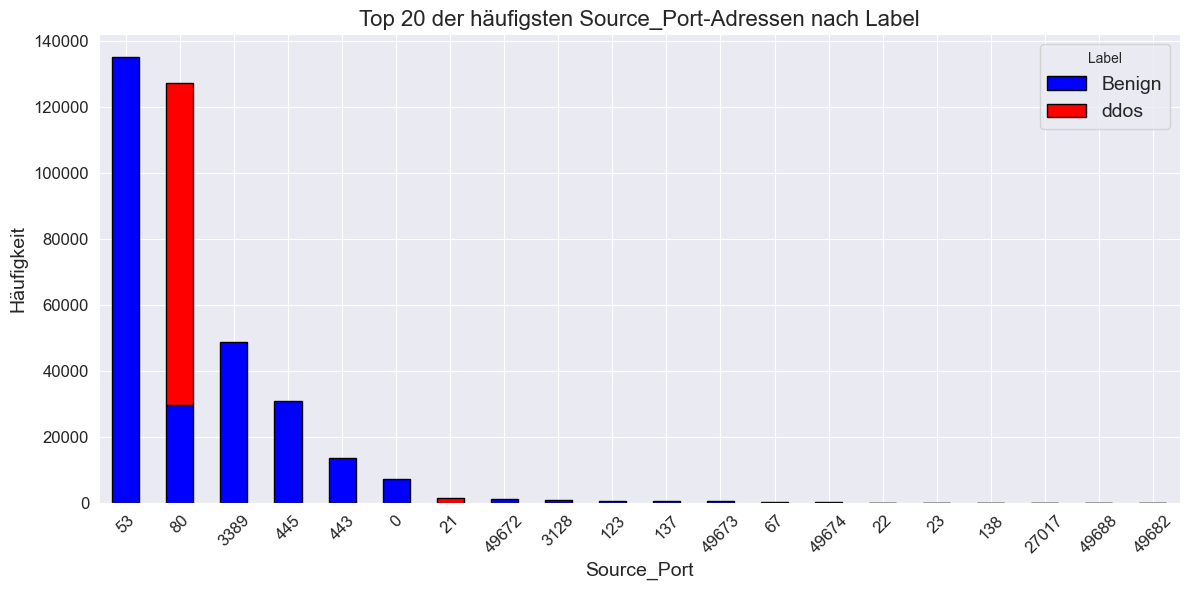

In [39]:
# Top 20 der häufigsten Source_Port-Adressen nach Label
source_ip_counts = df.groupby(['Source_Port', 'Label']).size().unstack().fillna(0)
top_20_source_ips = source_ip_counts.sum(axis=1).nlargest(20)
top_20_source_ips_df = source_ip_counts.loc[top_20_source_ips.index]

top_20_source_ips_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue', 'red'], edgecolor='black')
plt.title('Top 20 der häufigsten Source_Port-Adressen nach Label', fontsize=16)
plt.xlabel('Source_Port', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Label', fontsize=14)

plt.tight_layout();

Die Grafik zeigt, dass inbesondere der Source-Port 80 für DDoS-Angriffe verwendet wird. Zudem wird ersichtlich, dass sich die Mehrheit der Kommunikation auf wenige Source-Ports beschränkt.

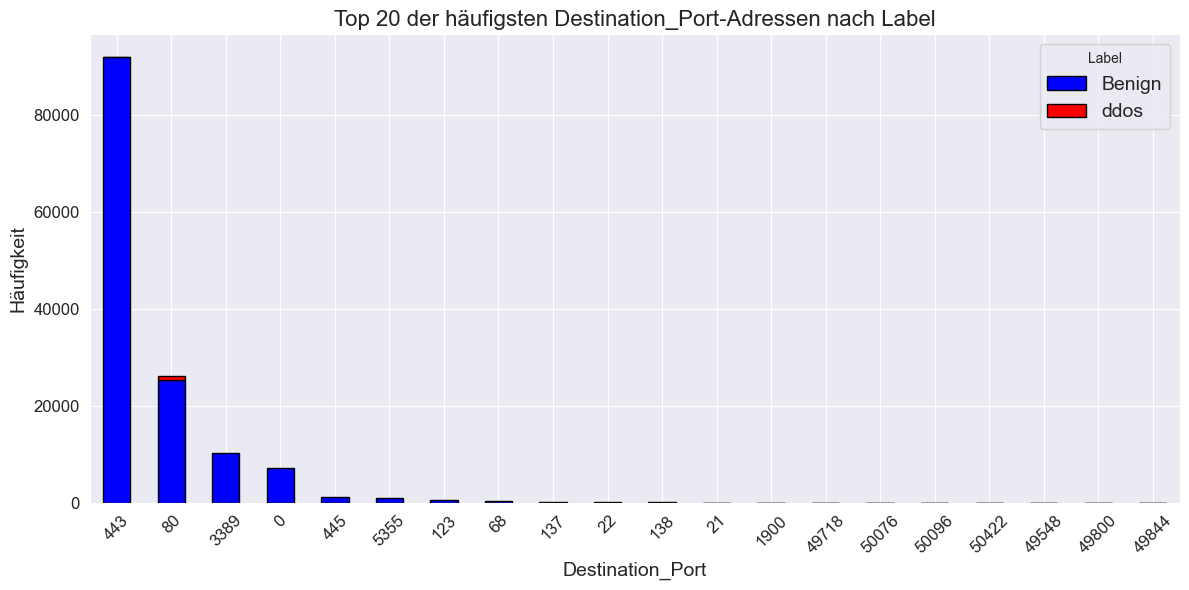

In [40]:
# Top 20 der häufigsten Destination_Port-Adressen nach Label
source_ip_counts = df.groupby(['Destination_Port', 'Label']).size().unstack().fillna(0)
top_20_source_ips = source_ip_counts.sum(axis=1).nlargest(20)
top_20_source_ips_df = source_ip_counts.loc[top_20_source_ips.index]

top_20_source_ips_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue', 'red'], edgecolor='black')
plt.title('Top 20 der häufigsten Destination_Port-Adressen nach Label', fontsize=16)
plt.xlabel('Destination_Port', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Label', fontsize=14)

plt.tight_layout();

Die obige Grafik erweckt den Eindruck, dass die durch DDoS-Angriffe betroffene Destination-Ports stark varrieren. Der normale Datenverkehr konzentriert sich auf die Ports 443, 80, 3389 und 0.

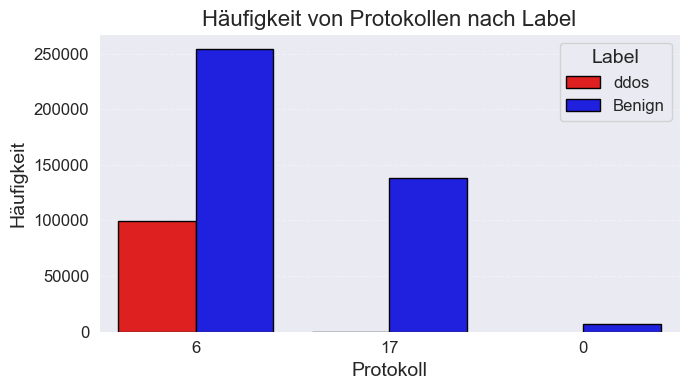

In [41]:
# Häufigkeit der Protokolle nach Label
plt.figure(figsize=(7, 4))
sns.countplot(x='Protocol', hue='Label', data=df, palette={'Benign': 'blue', 'ddos': 'red'}, edgecolor='black')

plt.title('Häufigkeit von Protokollen nach Label', fontsize=16)
plt.xlabel('Protokoll', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Label', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout();

Aus der obigen Grafik ist ersichtlich, dass sämtliche DDoS-Angriffe über das Protokoll 6 stattfinden. In diesem Datensatz sind keine DDoS-Angriffe über die Protokolle 17 oder 0 verzeichnet.

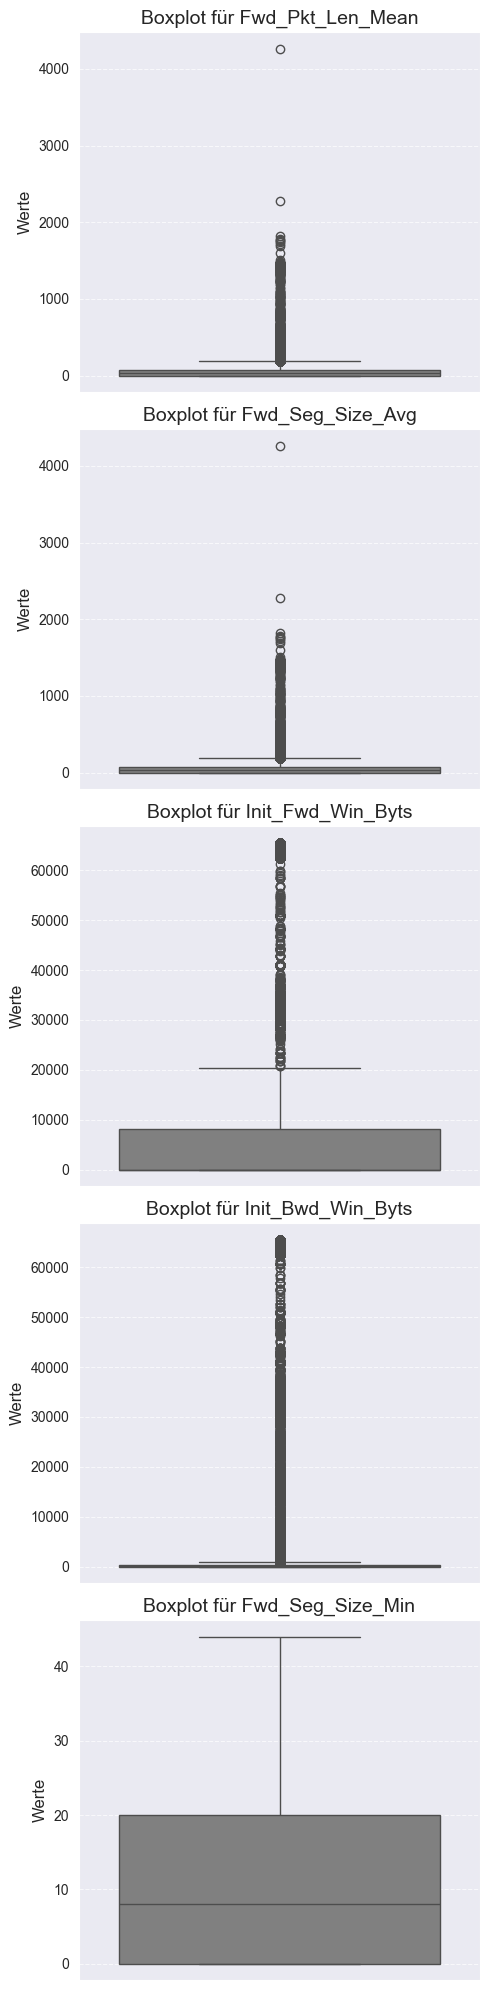

In [42]:
# Boxplots for numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Create Subplots
num_features_count = len(numerical_features)
fig, axes = plt.subplots(nrows=num_features_count, ncols=1, figsize=(5, 4 * num_features_count))

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, y=feature, ax=axes[i], color='grey')
    axes[i].set_title(f'Boxplot für {feature}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Werte', fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout();

Die Boxplot verdeutlichen sehr gut die Abweichung der Ausreißer vom Median. Da jedoch wie bereits erwähnt, davon ausgegangen wird, dass diese Werte der Realität entsprechen, werden diese in der Datenvorverarbeitung beibehalten.

Zudem zeigt sich, dass sich der Großteil der Ausprägungen auf kleine Intervalle beschränkt, wodurch die Boxplots dazu neigen, stark zusammengedrückt zu wirken.

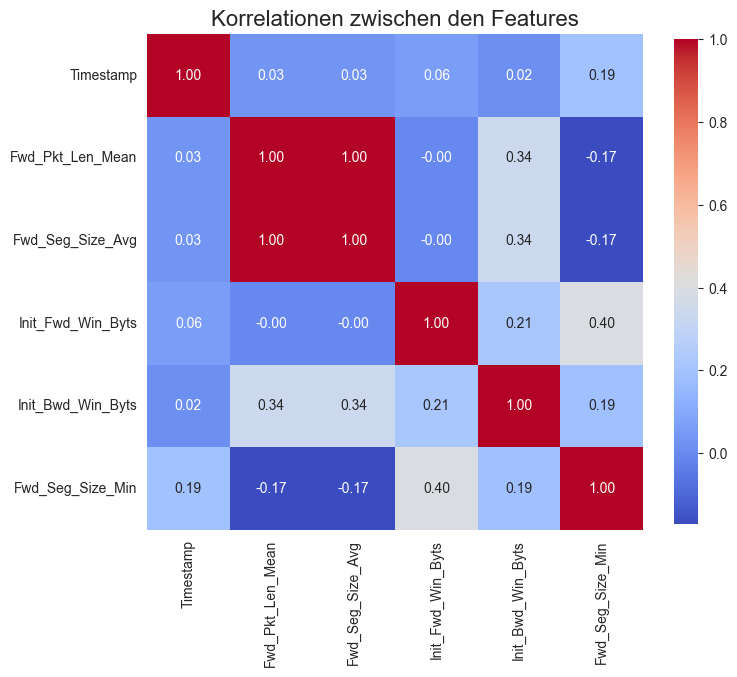

In [43]:
# creating correlation matrix
df_correlation = df.drop(['Flow_ID', 'Label', 'Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol'], axis=1)
correlation_matrix = df_correlation.corr()

# Heatmap of correlation
plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={'shrink': .9})
plt.title('Korrelationen zwischen den Features', fontsize=16);

Die Korrelationsmatrix zeigt, dass die Features Fwd_Seg_Size_Avg und Fwd_Pkt_Len_Mean eine perfekte positive Korrelation (Korrelation = 1) aufweisen, was darauf hindeutet, dass sie vollständig miteinander abhängen. Abgesehen von einer moderaten Korrelation von 0.4 zwischen den Features Init_Fwd_Win_Byts und Fwd_Seg_Size_Min, bestehen keine weiteren signifikanten Abhängigkeiten zwischen den numerischen Variablen im Datensatz.

## 4. Feature Engineering 

### 4.1 Annahmen und Erläuterung der Feature-Auswahl 

In [44]:
df.head(1) 

,Flow_ID,Timestamp,Fwd_Pkt_Len_Mean,Fwd_Seg_Size_Avg,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Seg_Size_Min,Label,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol
34877,192.168.4.118-203.73.24.75-4559-80-6,2010-06-12 08:37:25,46.0,46.0,-1,5840,0,ddos,192.168.4.118,203.73.24.75,4559,80,6


Es wird davon ausgegangen, dass das Erkennen des Labels unabhängig von der Source_IP und Destination_IP erfolgen soll. Des weiteren gilt, dass dieser Datensatz nicht als "saubere" Zeitreihe gelten kann, da unterschiedliche - nicht unbedingt miteinandner verbundene - Sachverhalte in diesen Datensatz enthalten sind. Dem Source_Port und Destination_Port werden Potential zur Lösung des Problems beigemessen, da jedoch sehr viele Merkmalsaussprägungen bestehen (keine numerischen Merkmale!), werden diese Aussprägungen der Häufigkeit entsprechend in wenige Gruppen zusammengefasst. 

Daraus ergeben sich folgende Anpassungen die in den folgenden Codezeilen umgesetzt werden:
- Entfernen von Flow_ID
- Entfernen von Timestamp
- Entfernen von Source_IP
- Entfernen von Destination_IP
- Reduktion von Source_Port auf 10 Ausprägungen (TOP 9 + "Else")
- Reduktion von Destination_Port auf 10 Ausprägungen (TOP 9 + "Else")
- Neuvergabe der Indizes 

In [45]:
# Remove not needed coloumns
df_cleaned = df.drop(columns=['Flow_ID', 'Timestamp', 'Source_IP', 'Destination_IP'])

# Reduction of Source_Ports 
top_source_ports = df_cleaned['Source_Port'].value_counts().nlargest(9).index
df_cleaned['Source_Port'] = df_cleaned['Source_Port'].apply(lambda x: x if x in top_source_ports else 'Else')

# Reduction of Destination_Port 
top_destination_ports = df_cleaned['Destination_Port'].value_counts().nlargest(9).index
df_cleaned['Destination_Port'] = df_cleaned['Destination_Port'].apply(lambda x: x if x in top_destination_ports else 'Else')

# Reset Index
df_cleaned.reset_index(drop=True, inplace=True)

df_cleaned.sample(5) 

,Fwd_Pkt_Len_Mean,Fwd_Seg_Size_Avg,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Seg_Size_Min,Label,Source_Port,Destination_Port,Protocol
100918,49.333333,49.333333,8192,149,20,Benign,80,Else,6
355859,127.555556,127.555556,8192,62852,20,Benign,3389,Else,6
345936,37.000000,37.000000,-1,-1,8,Benign,53,Else,17
86915,143.500000,143.500000,8192,62852,20,Benign,3389,Else,6
299685,36.500000,36.500000,254,7682,20,Benign,49672,443,6


### 4.2 Definition des Ausgangsdatensatz

df_cleaned dient als Ausgangsdatensatz für alle Modelle. Weiterführende Änderungen werden entsprechenden den Anforderungen der Modellen in deren Kapiteln durchgeführt.

In [46]:
quality(df_cleaned)

Dataframe has 500,000 rows and 9 columns.

0 column(s) with missing values.

4 column(s) with outliers.



,type,unique,missing_abs,missing_rel,outliers_abs,outliers_rel
Fwd_Pkt_Len_Mean,float64,15620,0,0.0,46202,9.24
Fwd_Seg_Size_Avg,float64,15388,0,0.0,46202,9.24
Init_Fwd_Win_Byts,int64,2442,0,0.0,12118,2.42
Init_Bwd_Win_Byts,int64,4033,0,0.0,122773,24.55
Fwd_Seg_Size_Min,int64,9,0,0.0,0,0.00
Label,object,2,0,0.0,0,0.00
Source_Port,object,10,0,0.0,0,0.00
Destination_Port,object,10,0,0.0,0,0.00
Protocol,object,3,0,0.0,0,0.00


## 5. Erstellung des Trainings- und Testdatensatzes

Entsprechend der Angabe: "Aufgrund der vielen Datensätze sollen die 100.000 aktuellsten Datensätze gleich zu Beginn als 
Testdatensätze entfernt werden."

In [88]:
test_data = df_cleaned.tail(100_000)  # df_cleaned is sorted by date 
train_data = df_cleaned.head(len(df) - 100_000) 

# Mix data and reset index
test_data = shuffle(test_data).reset_index(drop=True)
train_data = shuffle(train_data).reset_index(drop=True)

X_train = train_data.drop(columns='Label')
y_train = train_data['Label']

X_test = test_data.drop(columns='Label')
y_test = test_data['Label']

print(f"Anzahl der Testdatensätze: {len(test_data)}")
print(f"Anzahl der Trainingsdatensätze: {len(train_data)}")

Anzahl der Testdatensätze: 100000
Anzahl der Trainingsdatensätze: 400000


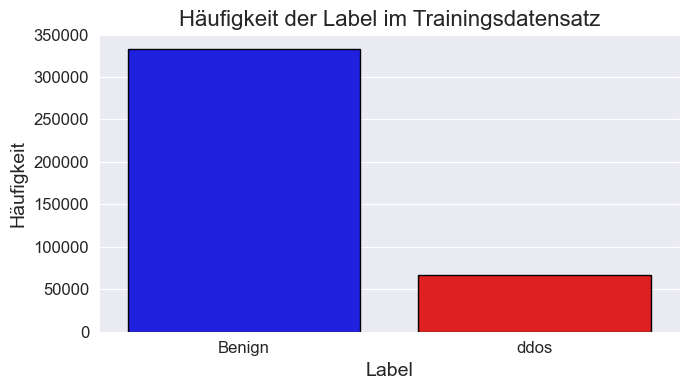

In [89]:
# Häufigkeit der Label im Trainingsdatensatz
plt.figure(figsize=(7, 4))
sns.countplot(x='Label', hue='Label', data=train_data, palette={'Benign': 'blue', 'ddos': 'red'}, edgecolor='black')
plt.title('Häufigkeit der Label im Trainingsdatensatz', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

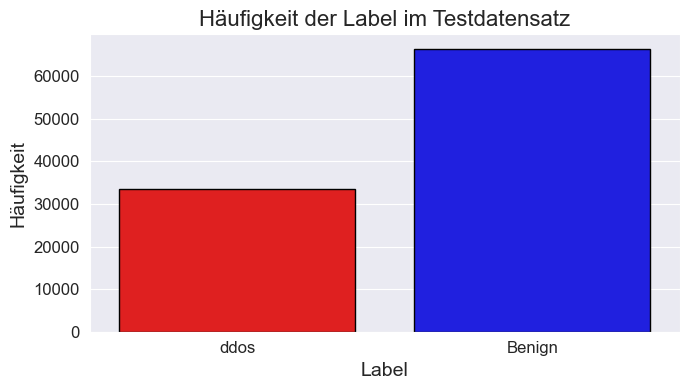

In [90]:
# Häufigkeit der Label im Testdatensatz
plt.figure(figsize=(7, 4))
sns.countplot(x='Label', hue='Label', data=test_data, palette={'Benign': 'blue', 'ddos': 'red'}, edgecolor='black')
plt.title('Häufigkeit der Label im Testdatensatz', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Häufigkeit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

Anhand der obigen Grafiken wurde kontrolliert, ob in beiden Datensätzen beide Labels vertreten sind.

## 6. Pipeline

In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
pca = PCA(n_components=.95)

categorical_cols = [ 'Source_Port', 'Destination_Port', 'Protocol']
numerical_cols = X_train.columns.difference(categorical_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

steps = [('scaler', preprocessor),
         ('pca', pca),
         ('classifier', LogisticRegression(max_iter=1000))]

pipe = Pipeline(steps)

In [92]:
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        'pca__n_components': [5, 15, 30, 45],
        'classifier': [LogisticRegression(max_iter=10000)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'pca__n_components': [5, 15, 30, 45],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'pca__n_components': [5, 15, 30, 45],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

gridpoints = len(ParameterGrid(param_grid))

print('Anzahl Parameterkombinationen: ', gridpoints)

Anzahl Parameterkombinationen:  72


In [93]:
from sklearn.model_selection import RepeatedKFold

n_splits  = 5
n_repeats = 10
splits    = n_splits * n_repeats   # Anzahl Durhläufe pro Parameterkombination

cv = RepeatedKFold(n_splits= n_splits, n_repeats= n_repeats)

In [ ]:
from sklearn.model_selection import GridSearchCV
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html

import time
start = time.time()

search = GridSearchCV(pipe, param_grid, n_jobs= -1, scoring= 'accuracy', refit= True)
search.fit(X_train, y_train)

print('Anzahl Parameterkombis:', gridpoints)
print('Anzahl Training-Validation-Splits:', splits)
print('Anzahl Durchläufe:', gridpoints*splits)
end = time.time()
print('Dauer:', round(end - start), 'Sekunden')

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = y_test.astype(int)

y_test_pred = search.best_estimator_.predict(X_test)

y_test_pred = y_test_pred.astype(int)
print('Confusion Matrix(test):')
print(confusion_matrix(y_test, y_test_pred))   # sklearn.metrics.confusion_matrix(y_true, y_pred,....
print('Accuracy(test):', round(accuracy_score(y_test, y_test_pred)*100),'%')